In [67]:
from pyspark.sql import SparkSession
import shutil
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, md5, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder \
    .appName("analysis") \
    .config("spark.some.config.option", "config-value") \
    .getOrCreate()

In [3]:
df = spark.read.parquet("/home/jovyan/work/data/processed/")

## 1. Obteniendo monto total que facturará el proveedor del servicio por envíos de sms.

In [25]:
# Calculando el monto por cada fila de sms x cuota_sms_region
df_monto_total_sms = df.withColumn("monto_sms", F.col("sms") * F.col("cuota_sms_region"))

In [26]:
df_monto_total_sms.agg({"total_msmxregion": "sum"}).collect()[0][0]

391367.0

## 2. ID de los 100 usuarios con mayor facturación por envío de smsp.

In [34]:
# creando una window data
windowSpec = Window.orderBy(col("monto_sms").desc())

In [41]:
top_100 = df_monto_total_sms.withColumn("hashed_id_source", md5(col("id_source"))) \
                      .withColumn("rank", row_number().over(windowSpec)) \
                      .filter(col("rank") <= 100)
df_monto_total_sms.unpersist()0

In [50]:
top_100.select("id_source", "hashed_id_source", "monto_sms", "rank").show(10)

+---------+--------------------+---------+----+
|id_source|    hashed_id_source|monto_sms|rank|
+---------+--------------------+---------+----+
|      A2C|d7dcc6703e425a6e3...|    360.0|   1|
|      17D|7521526054bb89ba2...|    330.0|   2|
|      CF6|3f77e9dfaa037a763...|    320.0|   3|
|      1DF|ccc83e5d7011c8df9...|    316.0|   4|
|      162|82aa4b0af34c2313a...|    309.0|   5|
|      CEE|98a499caca616859e...|    282.0|   6|
|      068|fb8490a9504a36c21...|    248.0|   7|
|      FCA|17dfecb54551e0419...|    234.0|   8|
|      C82|41fc05922ac4a713b...|    222.0|   9|
|      A2C|d7dcc6703e425a6e3...|    218.0|  10|
+---------+--------------------+---------+----+
only showing top 10 rows



In [48]:
# Generando el Parquet
top_100.select("id_source", "hashed_id_source", "monto_sms").write \
    .mode("overwrite") \
    .option("compression", "gzip") \
    .parquet("/home/jovyan/work/data/top100users")

## 3. Graficar un histograma de cantidad de llamadas que se realizan por hora del día.

In [66]:
# Numero de llamadas por hora en el día
calls_by_hour = df.groupBy(col("hour").alias("hour_of_day")).sum("calls").orderBy("hour_of_day")
calls_by_hour.show(25)

+-----------+----------+
|hour_of_day|sum(calls)|
+-----------+----------+
|          0|      6440|
|          1|      3222|
|          2|      1853|
|          3|      1514|
|          4|      1955|
|          5|      4090|
|          6|      9655|
|          7|     23033|
|          8|     43608|
|          9|     62837|
|         10|     74797|
|         11|     78792|
|         12|     80127|
|         13|     81541|
|         14|     77989|
|         15|     75304|
|         16|     72227|
|         17|     71417|
|         18|     70742|
|         19|     70057|
|         20|     62158|
|         21|     46514|
|         22|     30933|
|         23|     16726|
+-----------+----------+



In [71]:
calls_by_hour_df = calls_by_hour.toPandas()

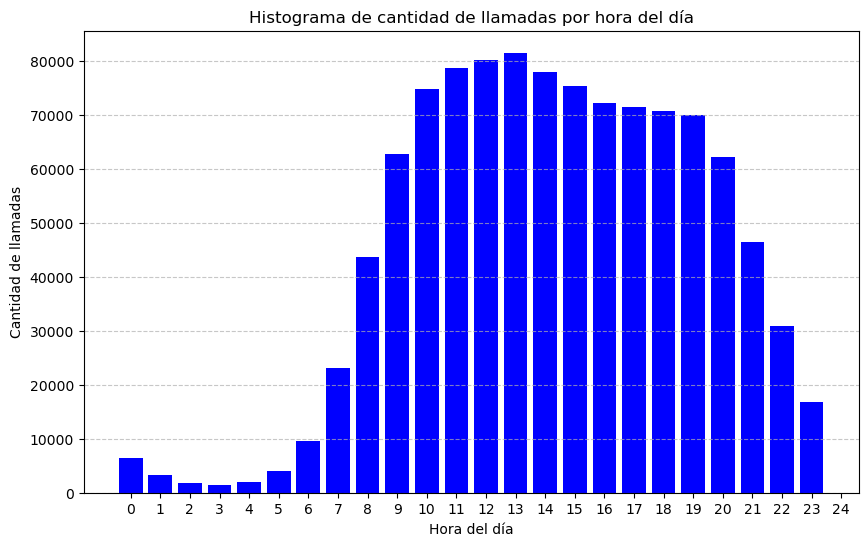

In [72]:
# Graficar el histograma
plt.figure(figsize=(10, 6))
plt.bar(calls_by_hour_df["hour_of_day"], calls_by_hour_df["sum(calls)"], color='blue')
plt.title("Histograma de cantidad de llamadas por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de llamadas")
plt.xticks(range(25))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()